In [0]:
# import time
# for i in range(10000): time.sleep(1)

In [0]:
import torch
from torch.utils import data
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import torchvision
import torchvision.models as models
from torchvision import transforms
from pathlib import Path
import PIL
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from PIL import Image

In [0]:
!pip install tensorboardcolab
from tensorboardcolab import TensorBoardColab

Using TensorFlow backend.


## Turning on cuda gpu

In [0]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
cudnn.benchmark = True

## Getting data

#### Defining dataloader params and normalizing values

In [0]:
params = {'batch_size': 5,
          'shuffle': True,
          'num_workers': 4}

data_mean = [0.485, 0.456, 0.406]
data_std = [0.229, 0.224, 0.225]

#### Defining custom tranform for target

In [0]:
class ConvertToBackground(object):
  def __call__(self, img):
    img = np.asarray(img, dtype=np.long)
    img[img == 255] = 0
    img = torch.from_numpy(img)
    return img

#### Wrapping transforms

In [0]:
img_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=data_mean, std=data_std)
])

target_transform = transforms.Compose([
    transforms.Resize((224,224)),
    ConvertToBackground()
])

#### Loading data using dataloaders

In [0]:
train_set = torchvision.datasets.VOCSegmentation(root='/content/data/train', year='2012', image_set='train', download=True, \
                                             transform=img_transform, target_transform=target_transform)
train_generator = data.DataLoader(train_set, **params)

val_set = torchvision.datasets.VOCSegmentation(root='/content/data/val', year='2012', image_set='val', download=True, \
                                            transform=img_transform, target_transform=target_transform)
val_generator = data.DataLoader(val_set, **params)

## Downloading pretrained vgg16 model

In [0]:
vgg16 = models.vgg16(pretrained=True)

#### Freezing convolution layers

In [0]:
for param in vgg16.features.parameters():
  param.requires_grad = False

## Defining FCN32 network

In [0]:
class FCN32(nn.Module):
  def __init__(self):
    super(FCN32, self).__init__()
    self.features = vgg16.features
    self.classifier = nn.Sequential(
      nn.Conv2d(512, 4096, 7),
      nn.ReLU(inplace=True),
      #nn.Dropout2d(),
      nn.Conv2d(4096, 4096, 1),
      nn.ReLU(inplace=True),
      #nn.Dropout2d(),
      nn.Conv2d(4096, 21, 1),
      nn.ConvTranspose2d(21, 21, 224, stride=32)
    )

  def forward(self, x):
    x = self.features(x)
    x = self.classifier(x)
    return x

fcn = FCN32()
fcn.to(device)

#### Checks to see proper weight updation and correct transfer

In [12]:
print('FEATURE parameters requires gradients: {}'.format(any([param.requires_grad for param in fcn.features.parameters()])))
print('CLASSIFIER parameters requires gradients: {}'.format(all([param.requires_grad for param in fcn.classifier.parameters()])))
print('Transferred FEATURE parameters from VGG16 to FCN: {}'.format(list(fcn.features.parameters()) == list(vgg16.features.parameters())))
print('Number of params transfered: {}'.format(sum(p.numel() for p in fcn.features.parameters())))
print('Number of params left in network to be updated: {}'.format(sum(p.numel() for p in fcn.classifier.parameters())))

FEATURE parameters requires gradients: False
CLASSIFIER parameters requires gradients: True
Transferred FEATURE parameters from VGG16 to FCN: True
Number of params transfered: 14714688
Number of params left in network to be updated: 119631893


## Defining FCN16 network

In [0]:
class FCN16(nn.Module):
  def __init__(self):
    super(FCN16, self).__init__()
    self.features = vgg16.features
    self.classifier = nn.Sequential(
      nn.Conv2d(512, 4096, 7),
      nn.ReLU(inplace=True),
      nn.Conv2d(4096, 4096, 1),
      nn.ReLU(inplace=True),
      nn.Conv2d(4096, 21, 1)
    )
    self.score_pool4 = nn.Conv2d(512, 21, 1)
    self.upscore2 = nn.ConvTranspose2d(21, 21, 14, stride=2, bias=False)
    self.upscore16 = nn.ConvTranspose2d(21, 21, 16, stride=16, bias=False)

  def forward(self, x):
    pool4 = self.features[:-7](x)
    pool5 = self.features[-7:](pool4)
    pool5_upscored = self.upscore2(self.classifier(pool5))
    pool4_scored = self.score_pool4(pool4)
    combined = pool4_scored + pool5_upscored
    res = self.upscore16(combined)
    return res

fcn = FCN16()
fcn.to(device)

## Defining criterion and optimizer

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(fcn.parameters(), lr=0.0005)

## Defining function that calculates iou and dice score

In [0]:
def get_mean_iou(conf_mat, multiplier=1.0):
  cm = conf_mat.copy()
  np.fill_diagonal(cm, np.diag(cm) * multiplier)
  inter = np.diag(cm)
  gt_set = cm.sum(axis=1)
  pred_set = cm.sum(axis=0)
  union_set =  gt_set + pred_set - inter
  iou = inter.astype(float) / union_set
  mean_iou = np.nanmean(iou)
  return mean_iou

## Initializing tensorboard

In [15]:
tb = TensorBoardColab()

Wait for 8 seconds...
TensorBoard link:
https://b07f1e60.ngrok.io


## Backprop

In [16]:
best_loss = 1000000000
j = 0
for epoch in range(15):
  val_running_loss = 0
  iou_running_score = 0
  dice_running_score = 0
  fcn.train()
  for i, dat in enumerate(train_generator):
    j += 1
    # Get image, label pair
    inputs, labels = dat

    # Using GPU
    inputs = inputs.to(device)
    labels = labels.to(device)

    # Set parameter gradients to 0
    optimizer.zero_grad()

    # Forward pass for a batch
    outputs = fcn(inputs)

    # Compute loss
    loss = criterion(outputs, labels)

    # Backpropagate
    loss.backward()

    # Update the weights
    optimizer.step()

    # print training loss
    #print('[{}, {}] training loss:{}'.format(epoch+1, i+1, loss.item()))
    tb.save_value('Train Loss', 'train_loss', j, loss.item())

  fcn.eval()
  with torch.no_grad():
    for k, dat1 in enumerate(val_generator):
      # Get image, label pair
      inputs1, labels1 = dat1

      # Using GPU
      inputs1 = inputs1.to(device)
      labels1 = labels1.to(device)

      # Predicting segmentation for val inputs
      outputs1 = fcn(inputs1)

      # Compute CE loss and aggregate it
      loss1 = criterion(outputs1, labels1)
      val_running_loss += loss1

      # Reshaping prediction segmentations and actual segmentations for iou and dice score
      preds = torch.argmax(outputs1, dim=1).detach().cpu().numpy()
      gt = labels1.detach().cpu().numpy()

      # Compute confusion matrix
      conf_mat = confusion_matrix(y_pred=preds.flatten(), y_true=gt.flatten(), labels=list(range(21)))

      # Computing iou and dice scores and aggregating them
      iou_score = get_mean_iou(conf_mat=conf_mat)
      iou_running_score += iou_score
      dice_score = get_mean_iou(conf_mat=conf_mat, multiplier=2.0)
      dice_running_score += dice_score

    # Averaging loss and scores
    avg_val_loss = float(val_running_loss)/(k+1)
    avg_iou_score = float(iou_running_score)/(k+1)
    avg_dice_score = float(dice_running_score)/(k+1)

    if avg_val_loss < best_loss:
      best_loss = avg_val_loss
      torch.save(fcn.state_dict(), '/content/best_model_fcn16.pth.tar')

    # Visualizations for batch wise metrics
    print('epoch {}, validation loss: {}, iou score: {}, dice score: {}'.format(epoch+1, avg_val_loss, avg_iou_score, avg_dice_score))
    tb.save_value('Validation Loss', 'val_loss', epoch+1, avg_val_loss)
    tb.save_value('IOU', 'iou', epoch+1, avg_iou_score)
    tb.save_value('Dice Score', 'dice_score', epoch+1, avg_dice_score)

print('Finished Training')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


epoch 1, validation loss: 0.9748568830818966, iou score: 0.09990876633560282, dice score: 0.12340372616363053
epoch 2, validation loss: 0.8209417408910291, iou score: 0.12804397229321807, dice score: 0.15755709939427714
epoch 3, validation loss: 0.7360805643015894, iou score: 0.1402719349292543, dice score: 0.1771624636669392
epoch 4, validation loss: 0.633300570783944, iou score: 0.16391814763821244, dice score: 0.20557537920568622
epoch 5, validation loss: 0.5810835739661907, iou score: 0.1897266317388018, dice score: 0.23584864958345758
epoch 6, validation loss: 0.5624119725720635, iou score: 0.20317314438277237, dice score: 0.2509100162658322
epoch 7, validation loss: 0.5502175166689116, iou score: 0.21479202444040618, dice score: 0.26611466899474867
epoch 8, validation loss: 0.5251377500336746, iou score: 0.22960927557707148, dice score: 0.28203681634727823
epoch 9, validation loss: 0.5138230422447467, iou score: 0.23844106025920833, dice score: 0.292220399692453
epoch 10, validat

## Examining performance on entire validation set

#### Loading best saved model

In [17]:
model = FCN16()
model.load_state_dict(torch.load('/content/best_model_fcn16.pth.tar'))
model.to(device)
model.eval()

FCN16(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation

#### Calculating DICE score and Mean IOU on entire validation set

In [18]:
overall_conf_mat = np.zeros((21, 21))
with torch.no_grad():
  for k, dat1 in enumerate(val_generator):
    # Get image, label pair
    inputs1, labels1 = dat1

    # Using GPU
    inputs1 = inputs1.to(device)
    labels1 = labels1.to(device)

    # Predicting segmentation for val inputs
    outputs1 = model(inputs1)

    preds = torch.argmax(outputs1, dim=1).detach().cpu().numpy()
    gt = labels1.detach().cpu().numpy()

    # Compute confusion matrix
    conf_mat = confusion_matrix(y_pred=preds.flatten(), y_true=gt.flatten(), labels=list(range(21)))
    overall_conf_mat += conf_mat

print('DICE score: {}'.format(np.round(get_mean_iou(conf_mat=overall_conf_mat ,multiplier=2.0), 2)))
print('Mean IOU score: {}'.format(np.round(get_mean_iou(conf_mat=overall_conf_mat), 2)))

DICE score: 0.57
Mean IOU score: 0.42


## Visualizing results

In [0]:
def decode_segmap(image, nc=21):
   
  label_colors = np.array([(0, 0, 0),
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])
 
  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
   
  for l in range(0, nc):
    idx = image == l
    r[idx] = label_colors[l, 0]
    g[idx] = label_colors[l, 1]
    b[idx] = label_colors[l, 2]
     
  rgb = np.stack([r, g, b], axis=2)
  return rgb

In [0]:
params = {'batch_size': 1,
          'shuffle': True,
          'num_workers': 4}

val_gen = data.DataLoader(val_set, **params)

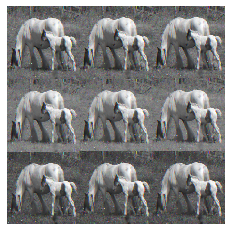

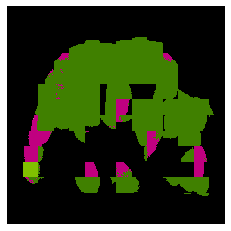

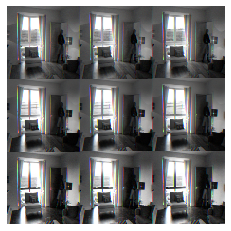

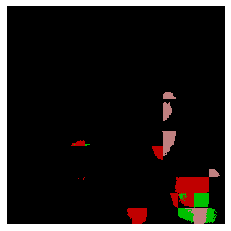

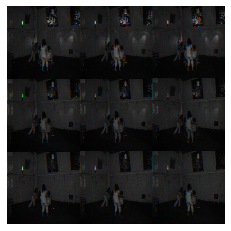

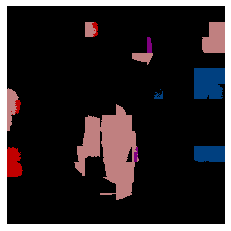

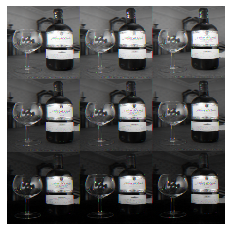

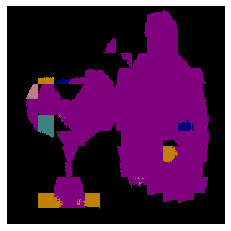

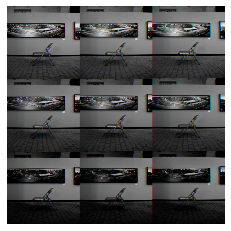

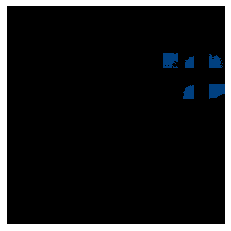

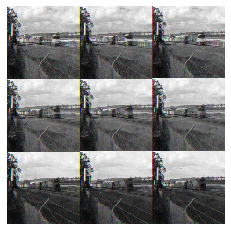

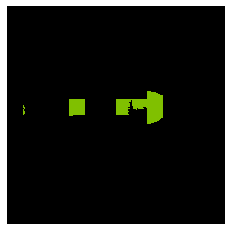

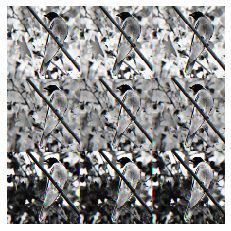

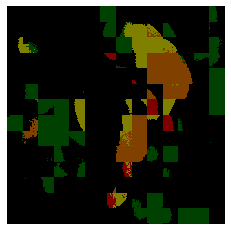

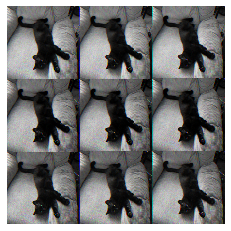

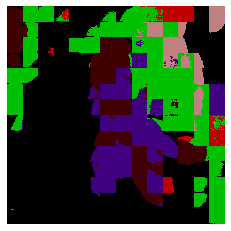

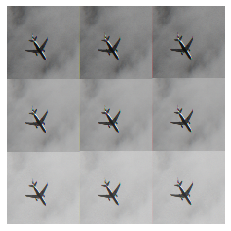

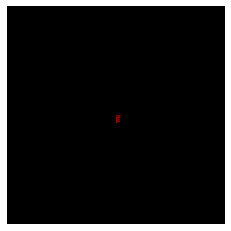

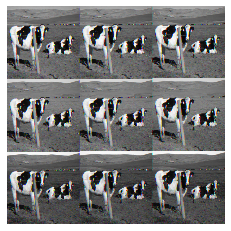

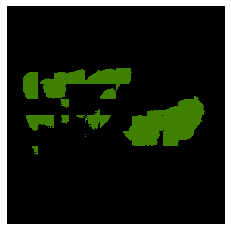

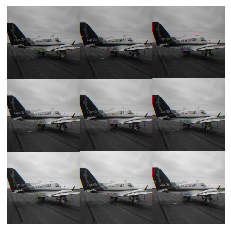

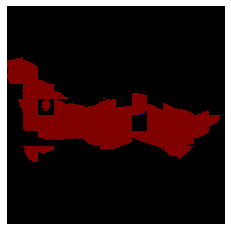

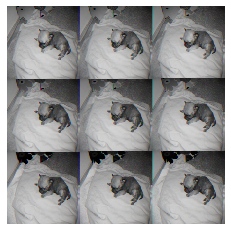

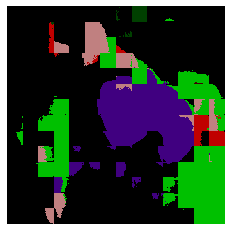

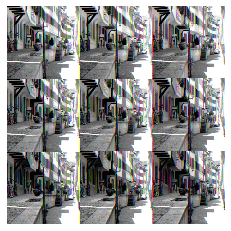

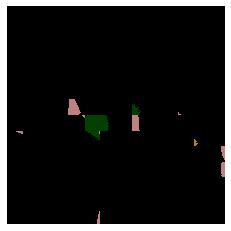

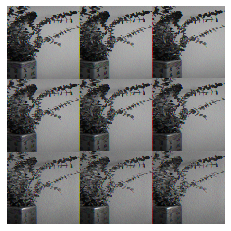

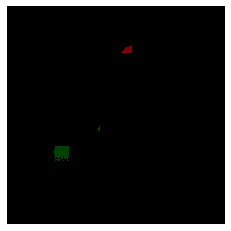

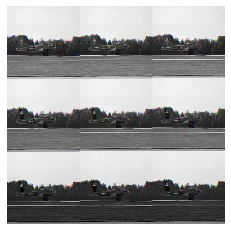

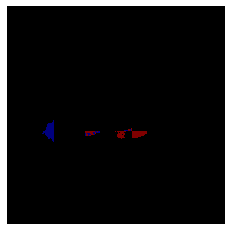

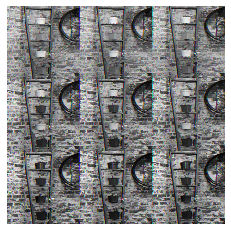

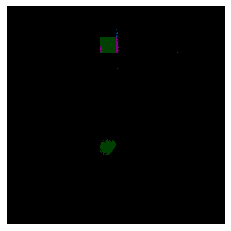

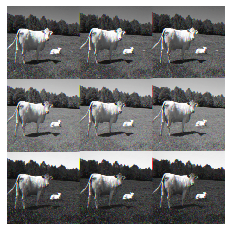

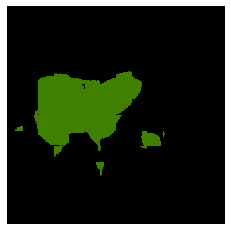

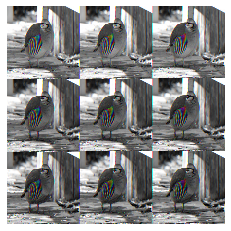

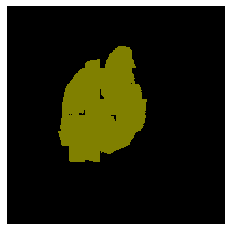

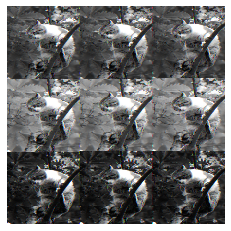

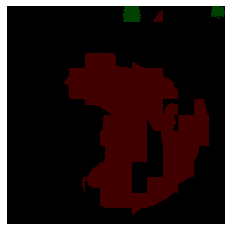

In [0]:
with torch.no_grad():
  for k, dat in enumerate(val_gen):
    # Get image, label pair
    inputs, labels = dat

    # Using GPU
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    outputs = model(inputs)
    pred = torch.argmax(outputs.squeeze(), dim=0).detach().cpu().numpy()
    
    # Getting the segmentation
    segmentation = decode_segmap(pred)

    # Getting the image
    z = inputs.squeeze() * torch.tensor(data_std).view(3, 1, 1).to(device)
    z = z + torch.tensor(data_mean).view(3, 1, 1).to(device)
    z = z.detach().cpu().numpy()
    z = z.reshape(z.shape[1], z.shape[2], z.shape[0])

    plt.imshow(Image.fromarray((z * 255).astype(np.uint8), 'RGB')); plt.axis('off'); plt.show()
    plt.imshow(segmentation); plt.axis('off'); plt.show()

## Steps to figure out
- Visualize results using colormap thing in PDF
- Use hook functions to code FCN-16